<a href="https://colab.research.google.com/github/hgabrali/Sentence-Polarity-Sentiment-Classifier/blob/main/NLP__guided_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Step 1: Importing Libraries**

In [19]:
# Importing necessary libraries
import numpy as np  # for numerical operations
import pandas as pd  # for data manipulation
import random  # for shuffling the data
import nltk
import re  # for handling regular expressions

from nltk.stem import WordNetLemmatizer  # for lemmatizing words
from nltk.corpus import stopwords  # for stop word removal
from nltk.tokenize import word_tokenize  # for tokenizing sentences into words

# Downloading necessary NLTK resources
nltk.download('stopwords')  # List of common stop words in English
nltk.download('punkt')  # Pre-trained tokenizer models
nltk.download('wordnet')  # WordNet lemmatizer dataset
nltk.download('punkt_tab')  # Downloads the 'punkt' tokenizer table used for tokenization of text into sentences or words

# Libraries for text feature extraction and model training
from sklearn.feature_extraction.text import TfidfVectorizer  # Convert text into numerical features (TF-IDF)
from sklearn.linear_model import LogisticRegression  # Logistic regression for classification
from sklearn.svm import LinearSVC  # Support Vector Machines for classification

# Libraries for model evaluation
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix  # For model evaluation metrics
from sklearn.model_selection import KFold, cross_val_score  # For cross-validation
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# **Step 2 & 3: Load & Prepare Dataset**

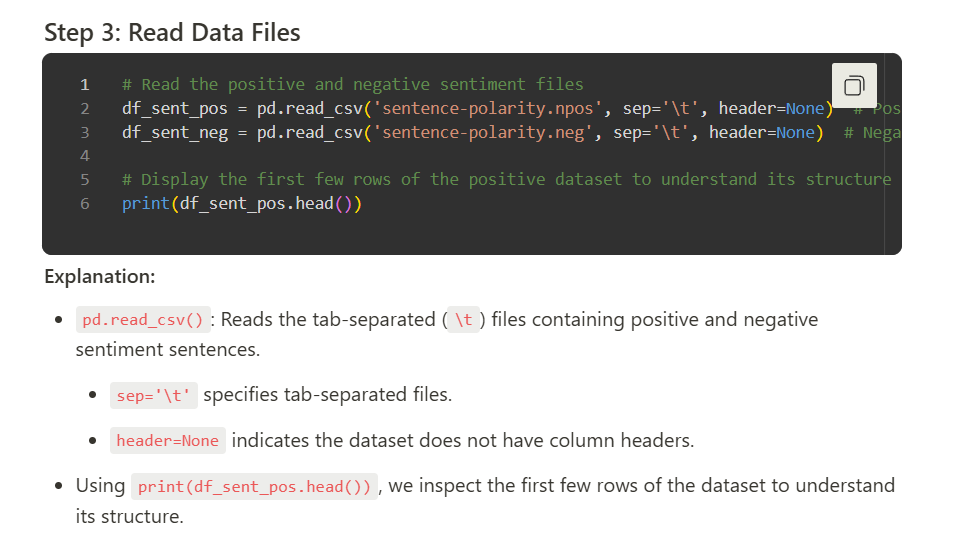

In [20]:
# Read the positive and negative sentiment files
df_sent_pos = pd.read_csv('https://raw.githubusercontent.com/chrisvdweth/nus-cs4248x/refs/heads/master/1-foundations/data/corpora/sentence-polarity-dataset/sentence-polarity.neg', sep='\t', header=None)  # Positive sentiment sentences
df_sent_neg = pd.read_csv('https://raw.githubusercontent.com/chrisvdweth/nus-cs4248x/refs/heads/master/1-foundations/data/corpora/sentence-polarity-dataset/sentence-polarity.pos', sep='\t', header=None)  # Negative sentiment sentences

# Display the first few rows of the positive dataset to understand its structure
print(df_sent_pos.head())

                                                   0
0                  simplistic , silly and tedious . 
1  it's so laddish and juvenile , only teenage bo...
2  exploitative and largely devoid of the depth o...
3  [garbus] discards the potential for pathologic...
4  a visually flashy but narratively opaque and e...


* The dataset has a single unnamed column (default column name is 0) containing text sentences.

In [21]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("nltkdata/sentence-polarity")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'sentence-polarity' dataset.
Path to dataset files: /kaggle/input/sentence-polarity


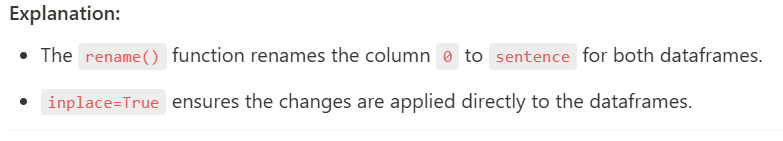

# **Step 4: Rename Columns**

In [22]:
# Rename the column to 'sentence'
df_sent_pos.rename(columns={0: "sentence"}, inplace=True)
df_sent_neg.rename(columns={0: "sentence"}, inplace=True)

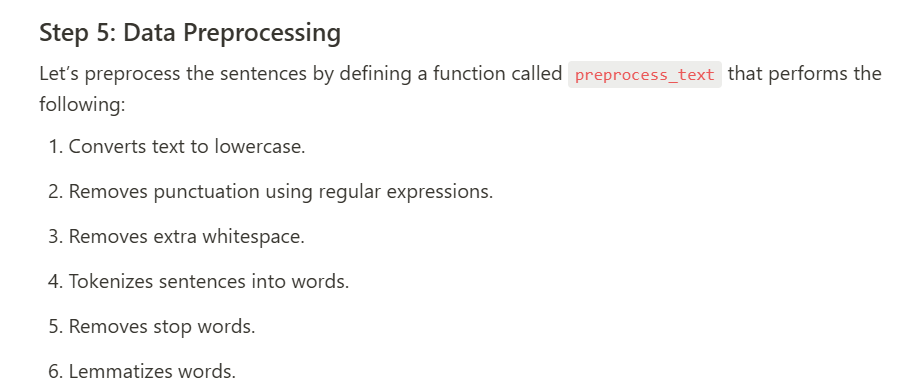

In [23]:
# Define the preprocessing function
def preprocess_text(sentences):
    # Convert all tokens to lowercase
    sentences = [sentence.lower() for sentence in sentences]

    # Remove punctuation using regex
    sentences = [re.sub(r"[^\w\s]", "", sentence) for sentence in sentences]

    # Remove extra whitespaces between words
    sentences = [" ".join(sentence.split()) for sentence in sentences]

    # Tokenize sentences into words
    sentences = [word_tokenize(sentence) for sentence in sentences]

    # Remove stop words
    stop_words = set(stopwords.words('english'))  # Load English stop words
    filtered_sentences = []
    for sentence in sentences:
        filtered_sentence = [word for word in sentence if word not in stop_words]
        filtered_sentences.append(filtered_sentence)

    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    lemmatized_sentences = []
    for sentence in filtered_sentences:
        lemmatized_sentence = [lemmatizer.lemmatize(word) for word in sentence]
        lemmatized_sentences.append(lemmatized_sentence)

    return [' '.join(sentence) for sentence in lemmatized_sentences]

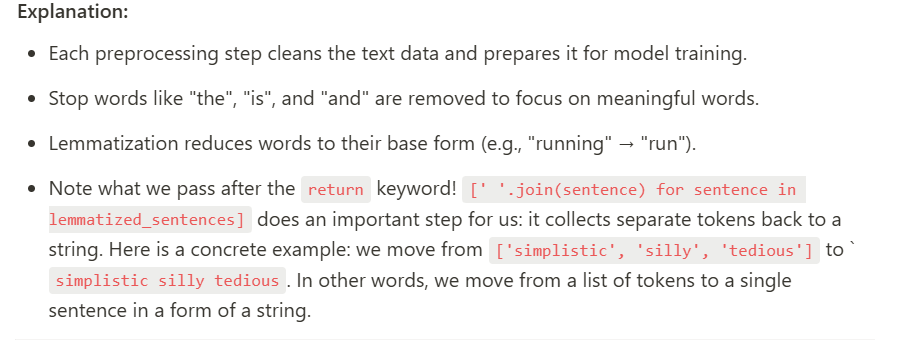

# **Step 6: Apply Preprocessing**

In [24]:
# Preprocess the sentences
pos_preprocessed_sentences = preprocess_text(df_sent_pos['sentence'])
neg_preprocessed_sentences = preprocess_text(df_sent_neg['sentence'])

# Print the first preprocessed negative sentence
print(neg_preprocessed_sentences[0])

rock destined 21st century new conan he going make splash even greater arnold schwarzenegger jeanclaud van damme steven segal


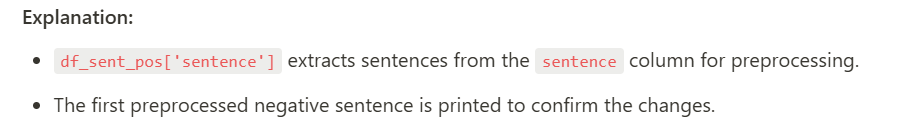

# **Step 7: Combine Datasets**

In [38]:
# Combine preprocessed positive and negative sentences. We merge the positive and negative sentences into a single list called sentences.
sentences = pos_preprocessed_sentences + neg_preprocessed_sentences

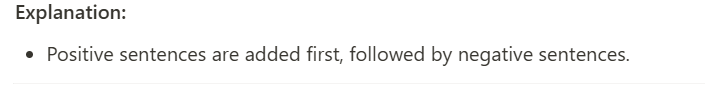

# **Step 8: Create Labels**

* Labels (also called targets) distinguish positive and negative sentences. Positive sentences are labeled as 1, and negative ones as 0.

In [26]:
# Create a list for all labels
polarities = []
polarities.extend([0] * len(df_sent_neg))  # Label negative sentences as 0
polarities.extend([1] * len(df_sent_pos))  # Label positive sentences as 1

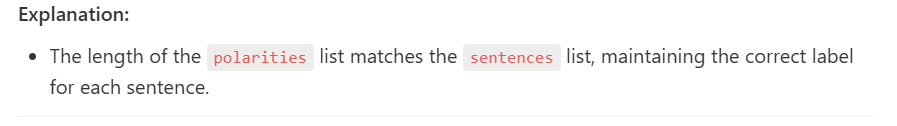

# **Step 9: Shuffle Data**

* Randomly shuffle the dataset to ensure sentences are in random order.

In [27]:
# Combine sentences and labels into a single list
combined = list(zip(sentences, polarities))

# Shuffle the combined list
random.shuffle(combined)

# Split the shuffled list back into sentences and labels
sentences[:], polarities[:] = zip(*combined)

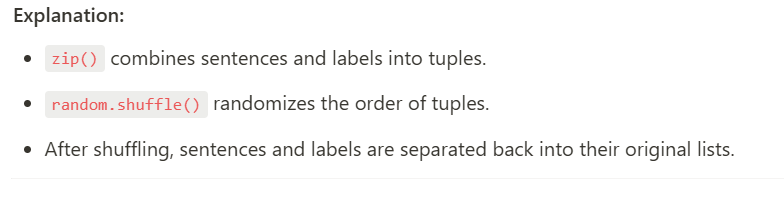

# **Step 10: Split Dataset**


* We’ll split the data into training and test sets, using 80% for training and 20% for testing.

In [28]:
# Define train-test split ratio
train_test_ratio = 0.8

# Calculate the size of the training set
train_set_size = int(train_test_ratio * len(sentences))

# Split data into training and test sets
X_train, X_test = sentences[:train_set_size], sentences[train_set_size:]
y_train, y_test = polarities[:train_set_size], polarities[train_set_size:]

# Print sizes of training and test sets
print("Size of training set:", len(X_train))
print("Size of test set:", len(X_test))

Size of training set: 8529
Size of test set: 2133


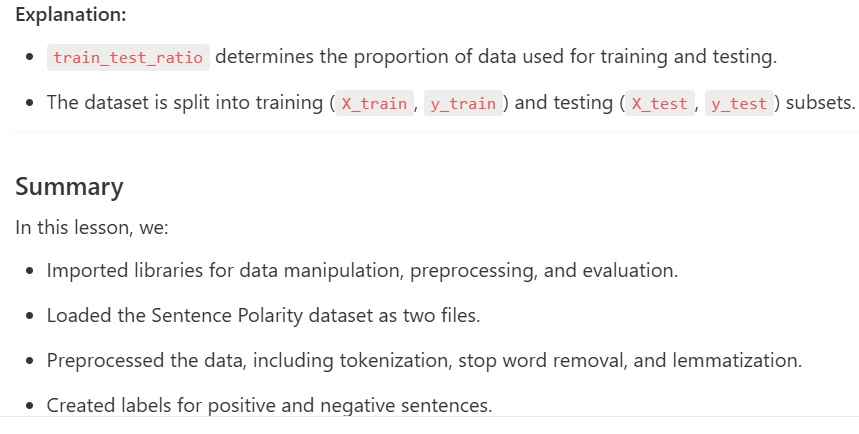

# **Step 11: Vectorizing Texts**

* We’ll transform our preprocessed text data into numerical features using the TF-IDF Vectorizer, train a classifier to predict sentiment, and evaluate how well the model performs on unseen data.

* TF-IDF stands for Term Frequency-Inverse Document Frequency. It measures how important a term is in a sentence, while reducing the weight of terms that occur frequently across many documents (like “the” or “and”).

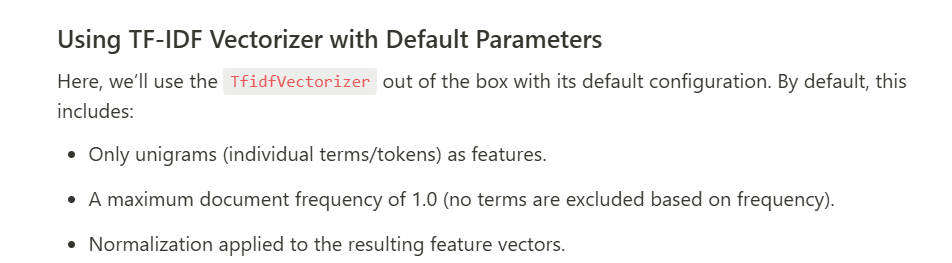

In [29]:
tfidf_vectorizer = TfidfVectorizer()

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

num_samples, num_features = X_train_tfidf.shape
print("#Samples: {}, #Features: {}".format(num_samples, num_samples))

#Samples: 8529, #Features: 8529


# **Step 12: Training the Classifier**

* With our feature matrix ready, we can train a Logistic Regression model. Logistic Regression is a simple yet effective algorithm for binary classification tasks, such as predicting sentiment polarity.

In [30]:
# Import the Logistic Regression model
from sklearn.linear_model import LogisticRegression

# Train the Logistic Regression classifier
logistic_regression_classifier = LogisticRegression(solver="sag").fit(X_train_tfidf, y_train)

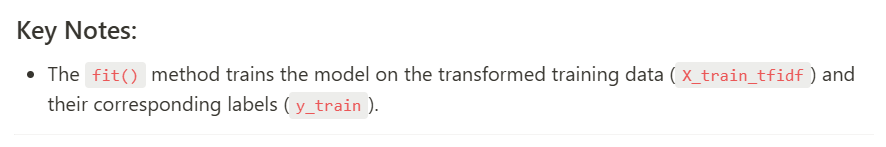

# **Step 13:  Evaluating the Classifier**

* After training the model, we need to assess its performance on unseen test data. Evaluation involves transforming the test data into the same TF-IDF format as the training data, making predictions, and calculating key metrics.



* 13.1: Transform Test Data
* 13.2: Predict Sentiment
* 13.3: Generate Evaluation Report

In [31]:
# Transform the test data
X_test_tfidf = tfidf_vectorizer.transform(X_test)

As we’ve mentioned, the first step for us is to transform the testing portion of data. It should be done in a similar manner to what we did with the training data.

* **ÖNEMLI:** The only difference is that with the testing data we always use the .transform() method instead of the .fit_transform() one.
The general rule here is that .fit_transform() is always used for the training data and .transform() for any other data.

In [32]:
# Predict polarities for the test data
y_pred = logistic_regression_classifier.predict(X_test_tfidf)

In [33]:
# Import evaluation metrics
from sklearn.metrics import classification_report, accuracy_score

# Generate the classification report. We use the classification_report() function to generate precision, recall, and F1-score metrics for each class, as well as the overall accuracy.
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.76      0.76      1056
           1       0.77      0.76      0.76      1077

    accuracy                           0.76      2133
   macro avg       0.76      0.76      0.76      2133
weighted avg       0.76      0.76      0.76      2133



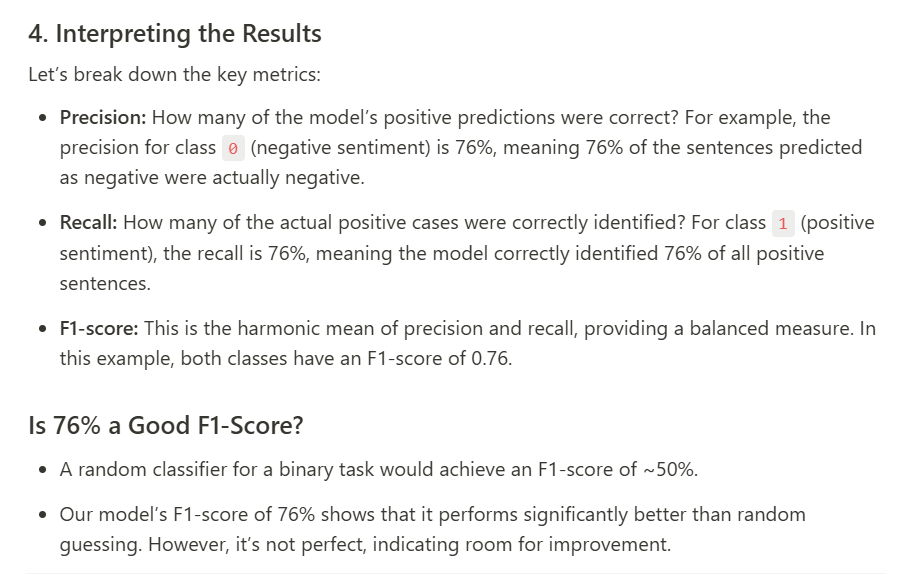

# **Step 14: Training Using K-Fold Cross Validation**

* K-fold cross-validation is a method that splits your dataset into k subsets (or folds) to evaluate your model's performance in a more reliable and generalizable way. It helps mitigate issues caused by a single train-test split, such as overfitting or underfitting, and gives a better estimate of how well your model will perform on unseen data.

In [34]:
# Import necessary library
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

# Perform 10-fold cross-validation on the training data
f1_scores_list = cross_val_score(
    LogisticRegression(),            # Model: Logistic Regression
    X_train_tfidf,                   # Features: TF-IDF transformed training data
    y_train,                         # Labels: Training labels
    cv=10,                           # Number of folds
    scoring="f1"                     # Evaluation metric: F1 score
)

# Display the F1 scores for each fold
print(f"F1 Scores for each fold: {f1_scores_list}")

# Calculate and display the mean and standard deviation of the F1 scores
print("F1 Score (Mean/Average): {:.3f}".format(f1_scores_list.mean()))
print("F1 Score (Standard Deviation): {:.3f}".format(f1_scores_list.std()))

F1 Scores for each fold: [0.75209581 0.74238876 0.75894988 0.76566125 0.75203725 0.75238095
 0.72439024 0.7579693  0.75603865 0.75058824]
F1 Score (Mean/Average): 0.751
F1 Score (Standard Deviation): 0.011


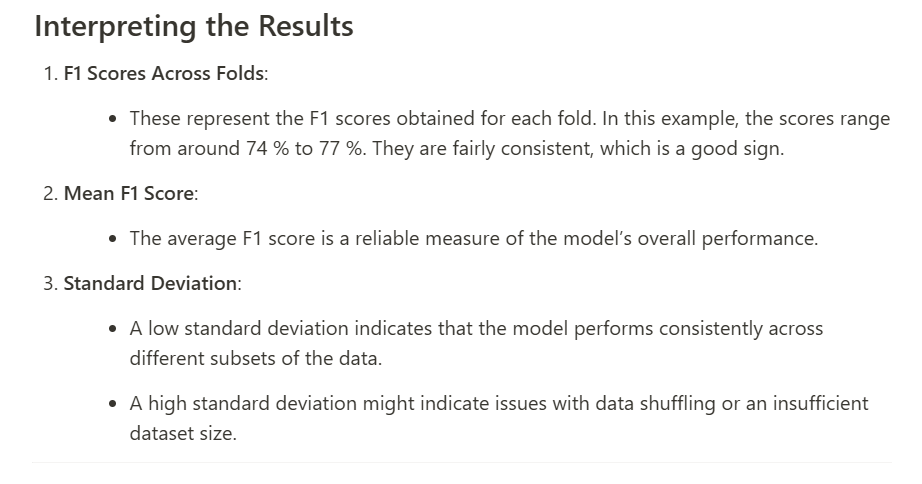

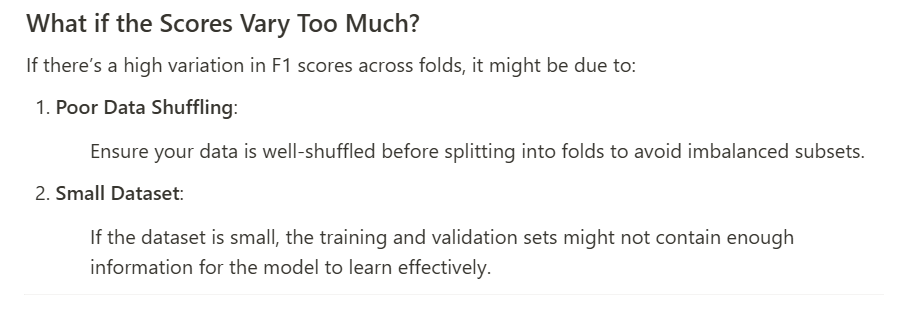

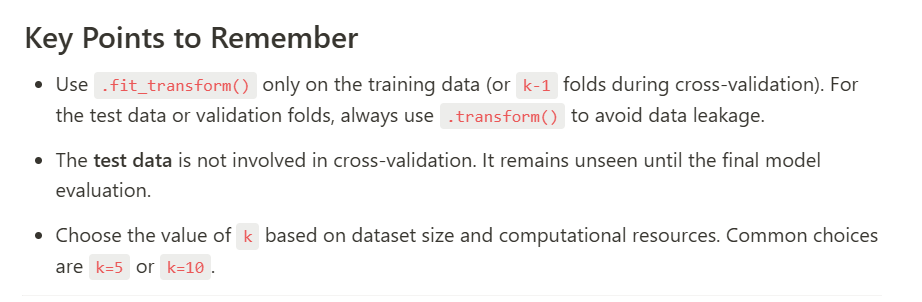

# **Step 15: Perform Hyperparameter Tuning**

* Hyperparameter tuning is the process of systematically searching for the best combination of these values to optimize a model's performance. The right configuration can make a significant difference in a model's accuracy and generalization ability, especially when dealing with complex datasets.

* We are going to use the n-gram parameter during TF-IDF vectorization, or general parameters like learning rates in neural networks.

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

# Initialize placeholders to store the best configuration
best_score = -1.0
best_classifier = None
best_ngram_size = -1

# Define the hyperparameters to test
classifiers = [LinearSVC(), LogisticRegression(solver="sag")]
ngram_sizes = [1, 2, 3, 4]

# Loop through all combinations of classifiers and n-gram sizes
for classifier in classifiers:
    for n in ngram_sizes:
        # Define the vectorizer with the current n-gram size
        vectorizer = TfidfVectorizer(ngram_range=(1, n))
        X_train_tfidf = vectorizer.fit_transform(X_train)  # Transform training data

        # Perform 10-fold cross-validation
        f1_scores = cross_val_score(classifier, X_train_tfidf, y_train, cv=10, scoring='f1')
        avg_f1_score = f1_scores.mean()  # Calculate average F1-score

        # Print the result for this combination
        print(f"Classifier: {type(classifier).__name__}, n-gram size: {n} => F1-score: {avg_f1_score:.3f}")

        # Save the best configuration
        if avg_f1_score > best_score:
            best_score = avg_f1_score
            best_classifier = classifier
            best_ngram_size = n

# Print the best configuration
print("\nBest Configuration:")
print(f"Classifier: {type(best_classifier).__name__}, Max n-gram size: {best_ngram_size}, F1-score: {best_score:.3f}")

Classifier: LinearSVC, n-gram size: 1 => F1-score: 0.744
Classifier: LinearSVC, n-gram size: 2 => F1-score: 0.756
Classifier: LinearSVC, n-gram size: 3 => F1-score: 0.751
Classifier: LinearSVC, n-gram size: 4 => F1-score: 0.748
Classifier: LogisticRegression, n-gram size: 1 => F1-score: 0.751
Classifier: LogisticRegression, n-gram size: 2 => F1-score: 0.745
Classifier: LogisticRegression, n-gram size: 3 => F1-score: 0.739
Classifier: LogisticRegression, n-gram size: 4 => F1-score: 0.735

Best Configuration:
Classifier: LinearSVC, Max n-gram size: 2, F1-score: 0.756


As a result, we found out that the best performance was achieved with the **LinearSVC model** and with the n-gram size set to 2.

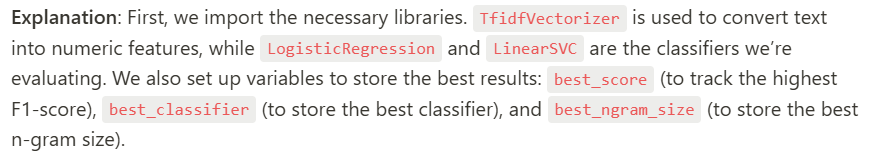

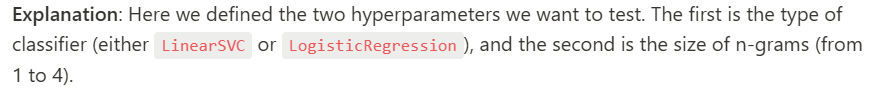

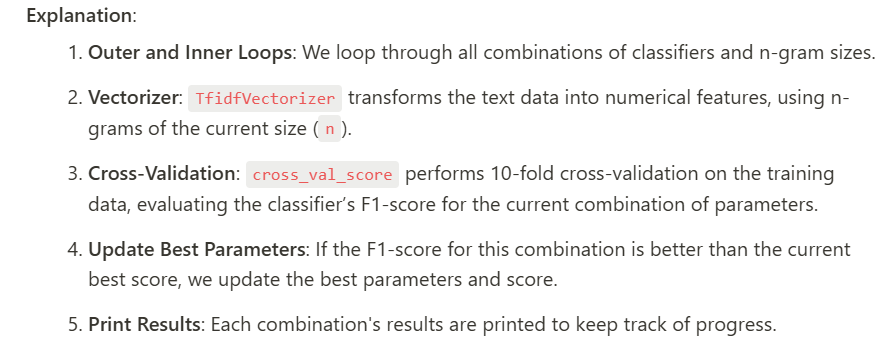

# **Step 16: Training the Best Model**

In [36]:
from sklearn.metrics import classification_report, accuracy_score

# Use the best configuration to train the final model
final_vectorizer = TfidfVectorizer(ngram_range=(1, best_ngram_size))
X_train_tfidf = final_vectorizer.fit_transform(X_train)
X_test_tfidf = final_vectorizer.transform(X_test)

best_classifier.fit(X_train_tfidf, y_train)
y_pred = best_classifier.predict(X_test_tfidf)

# Evaluate and display results
print("\nFinal Model Results:")
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")


Final Model Results:
              precision    recall  f1-score   support

           0       0.77      0.75      0.76      1056
           1       0.76      0.78      0.77      1077

    accuracy                           0.77      2133
   macro avg       0.77      0.77      0.77      2133
weighted avg       0.77      0.77      0.77      2133

Accuracy: 0.768


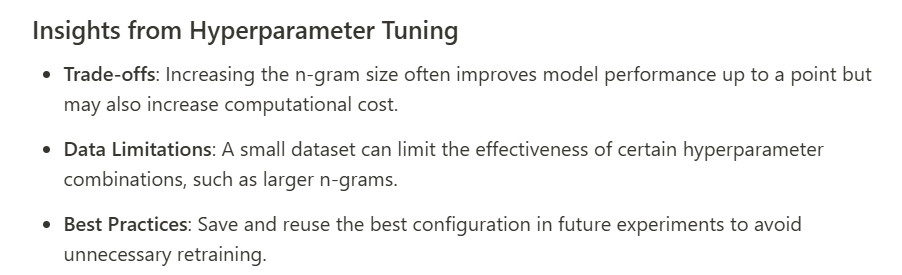